In [1]:
import os
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
import shap
import matplotlib.pyplot as plt
import graphviz
from sklearn.inspection import permutation_importance

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.chdir(r"D:\PAU document\Thesis\Analysis\Raster Datas\Input_Machine")

In [3]:
df = pd.read_csv("Input_raster_variables_observed.csv")
print(df.head())
print(df.shape)

     row   col         Flood        DEM     Aspect        LST  Curvature  \
0   1446   466  1.000000e+00  1091.4434  265.63922  30.465733  -0.882296   
1  12547  9845  0.000000e+00  2293.2332  195.32118  28.970543   1.117341   
2  10611  2922  1.460000e-11  1922.4335  225.00000  31.864056   0.000000   
3   7115  9716  0.000000e+00  1845.0000  146.19232  27.195745  -0.029038   
4   7020  7712  0.000000e+00  1785.0845  310.98590  21.077883  -0.420258   

   Hillshade      LULC        River         Road  Soil      Slope      SPI3  \
0  208.57971  4.562726   544.478638  2262.171143  22.0  19.355185 -0.001683   
1  169.44194  3.783454  2491.819580    58.499249   7.0   6.201397 -0.014699   
2  179.00000  5.000000  2012.050659   780.587463  12.0   6.091237 -0.008495   
3  180.09074  3.561093   106.502472  2710.281006   9.0   0.767772 -0.017318   
4  184.74039  5.000000  1619.145996  6337.947266  18.0   1.712441 -0.015713   

    Rainfall  
0  262.11862  
1  238.07439  
2  298.51373  
3  242.9

In [6]:
y = df["Flood"]
X = df.drop(columns=["row", "col", "Flood"])

## XGBoots

In [7]:
models = {}

# XGBoost
models["XGBoost"] = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [8]:
# Random Forest
models["RandomForest"] = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

In [9]:
# LightGBM
models["LightGBM"] = lgbm.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

In [10]:
# Decision Tree
models["DecisionTree"] = DecisionTreeRegressor(
    max_depth=None,
    random_state=42
)

In [11]:
# Train all models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X, y)

Training XGBoost...
Training RandomForest...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 18415, number of used features: 12
[LightGBM] [Info] Start training from score 0.281998
Training DecisionTree...


In [12]:
shap_values_models = {}

# Sample for SHAP
X_sample = shap.sample(X, 500, random_state=42)

for name, model in models.items():
    print(f"Computing FAST SHAP for {name}...")

    if name in ["XGBoost", "RandomForest", "LightGBM", "DecisionTree"]:
        
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="tree_path_dependent"
        )

        shap_values = explainer.shap_values(
            X_sample,
            check_additivity=False
        )

        # LightGBM sometimes returns list — take only the first
        if isinstance(shap_values, list):
            shap_values = shap_values[0]

        shap_values_models[name] = shap_values


Computing FAST SHAP for XGBoost...
Computing FAST SHAP for RandomForest...
Computing FAST SHAP for LightGBM...
Computing FAST SHAP for DecisionTree...


## Produce SHAP Summary Plots

In [13]:
# Set global font
plt.rcParams["font.family"] = "Times New Roman"


### SHAP summary plot: XGBoost ###


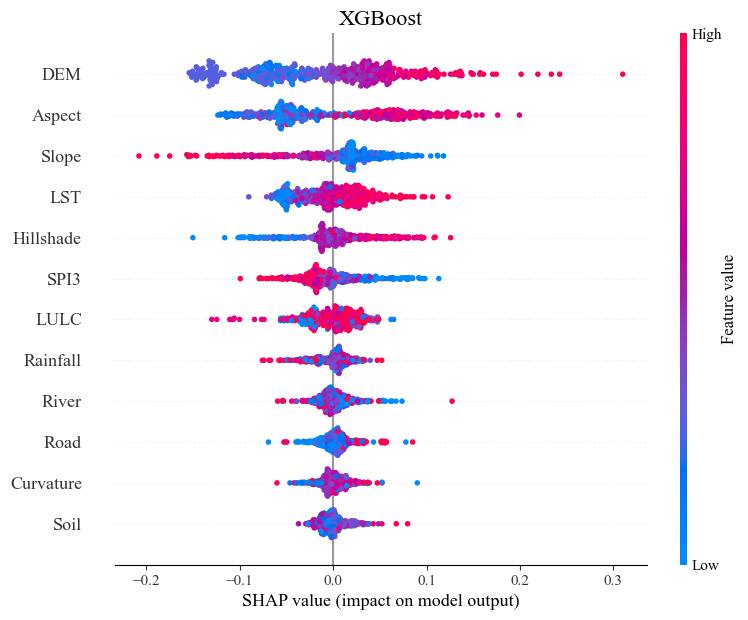


### SHAP summary plot: RandomForest ###


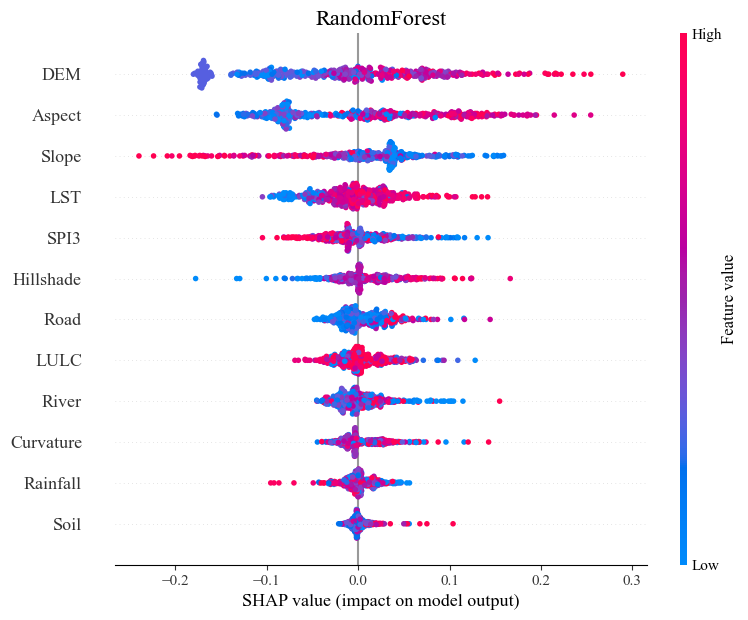


### SHAP summary plot: LightGBM ###


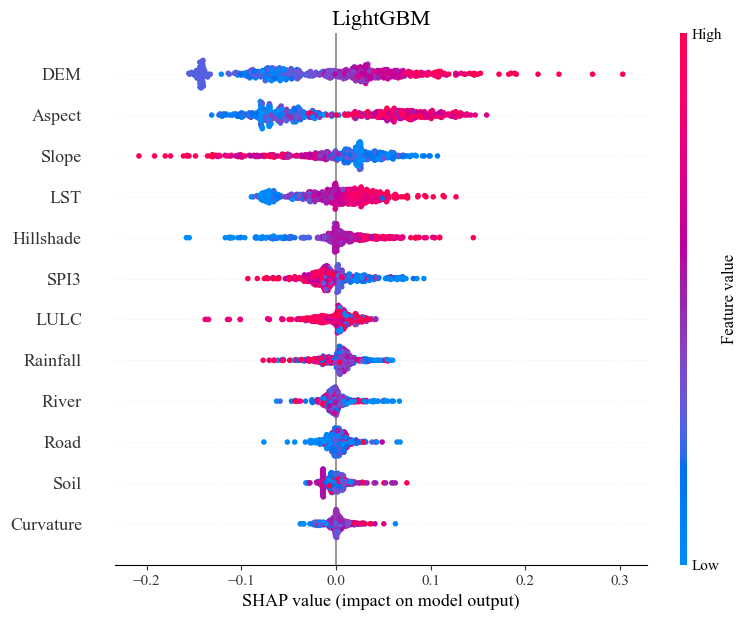


### SHAP summary plot: DecisionTree ###


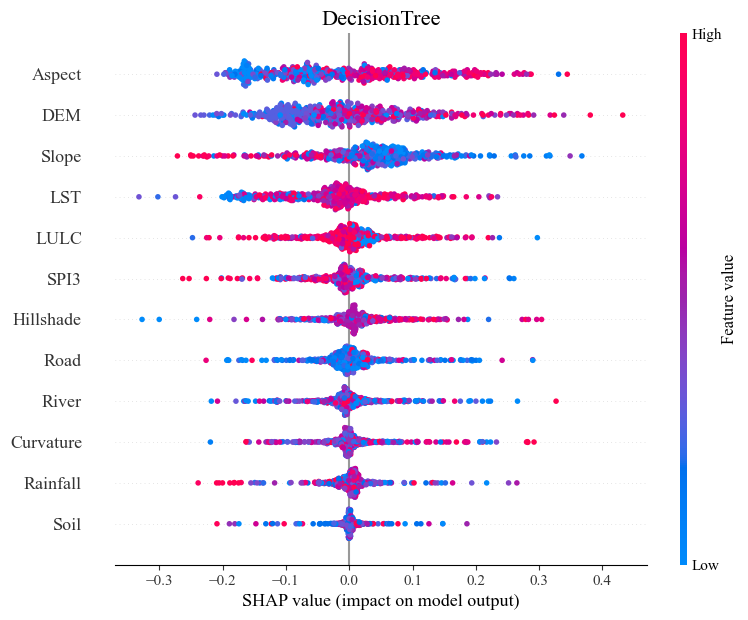

In [14]:
for name in ["XGBoost", "RandomForest", "LightGBM", "DecisionTree"]:
    print(f"\n### SHAP summary plot: {name} ###")

    shap_values = shap_values_models[name]

    # Downsample X to speed up SHAP plotting
    X_plot = shap.sample(X, 500, random_state=42)

    # Downsample SHAP values to the SAME number of rows
    shap_plot = shap_values[: X_plot.shape[0], :]

    # Create figure with title before plotting
    plt.figure()
    plt.title(f"{name}", fontfamily="Times New Roman", fontsize=16)

    shap.summary_plot(
        shap_plot,
        X_plot,
        max_display=20,
        show=True
    )

## Produce SHAP Bar Plots


### SHAP BAR plot: XGBoost ###


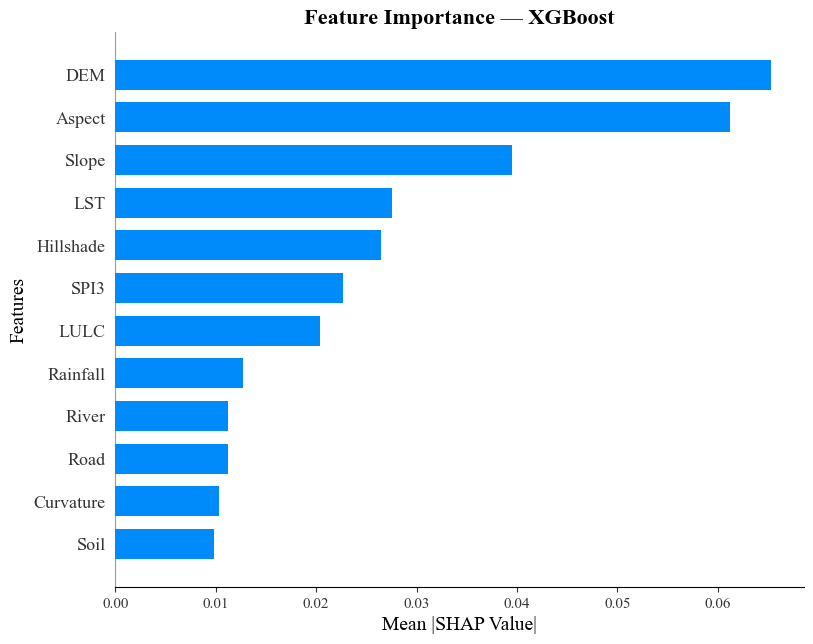


### SHAP BAR plot: RandomForest ###


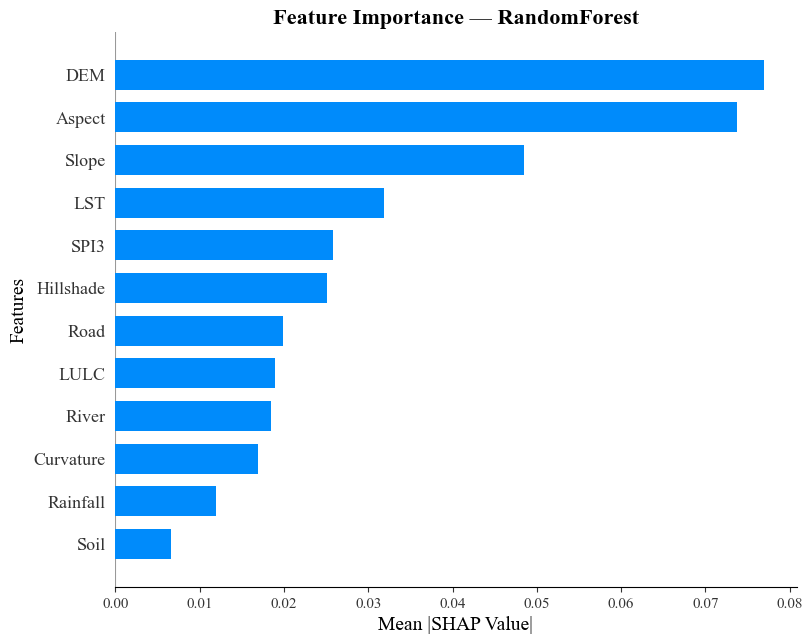


### SHAP BAR plot: LightGBM ###


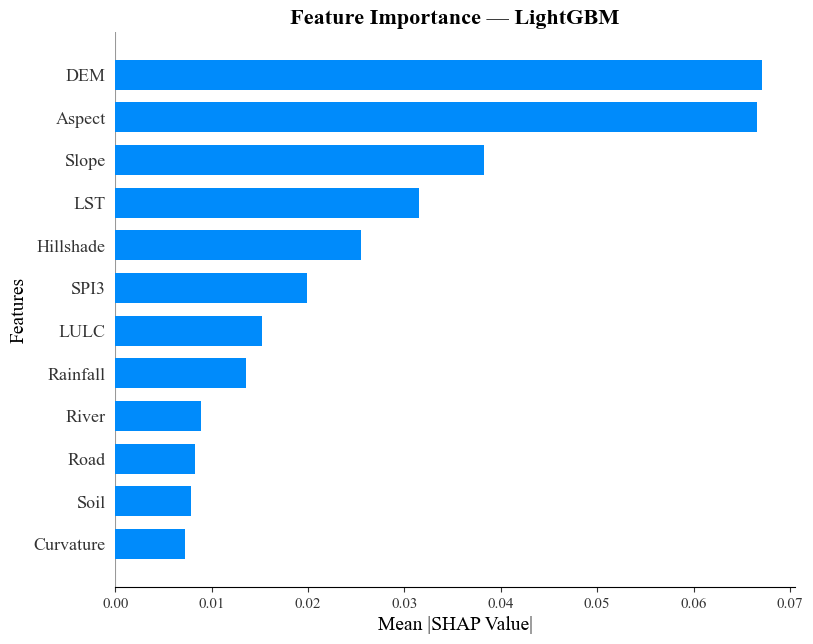


### SHAP BAR plot: DecisionTree ###


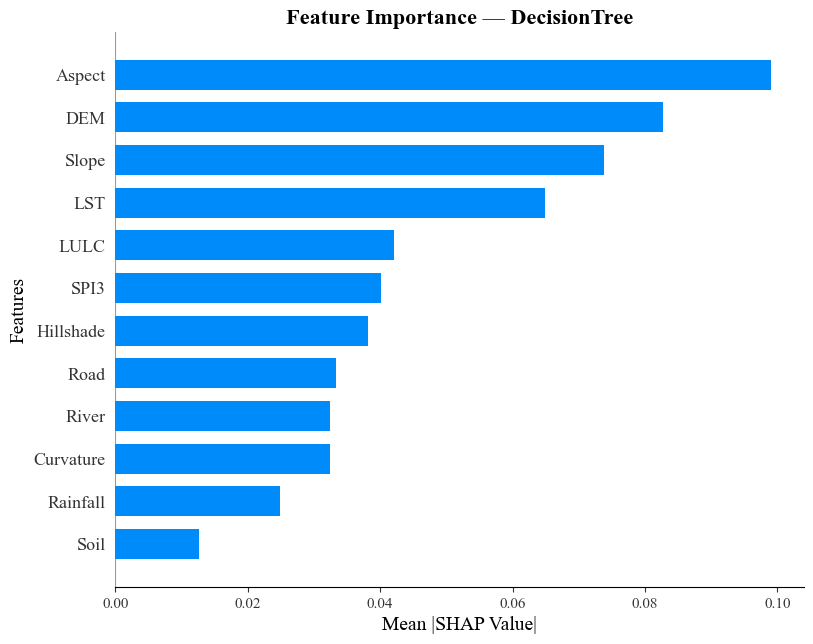

In [15]:
for name in models.keys():
    print(f"\n### SHAP BAR plot: {name} ###")

    shap_values = shap_values_models[name]

    shap.summary_plot(
        shap_values,
        X,
        plot_type="bar",
        show=False,
        title=f"SHAP Feature Importance — {name}"
    )

    plt.title(f"Feature Importance — {name}", fontsize=16, fontweight="bold")
    plt.xlabel("Mean |SHAP Value|", fontsize=14)
    plt.ylabel("Features", fontsize=14)
    plt.show()

## Create a Comparison Table of Feature Sensitivity

In [39]:
# Make sure feature names exist 
feature_names = X.columns.tolist()

In [40]:
comparison = {}

for name in models.keys():
    shap_vals = shap_values_models[name]
    mean_abs = np.abs(shap_vals).mean(axis=0)
    comparison[name] = mean_abs

df_compare = pd.DataFrame(comparison, index=feature_names)
df_compare["Average"] = df_compare.mean(axis=1)
df_compare = df_compare.sort_values("Average", ascending=False)

df_compare

,XGBoost,RandomForest,LightGBM,DecisionTree,Average
TCI,2.700297,3.058894,3.137410,3.214220,3.027705
NDVI,2.452846,2.740096,2.741052,2.920935,2.713732
DEM,0.689231,0.719837,0.841152,0.922083,0.793076
PCP,0.432960,0.293063,0.412166,0.573872,0.428015
MNDWI,0.222890,0.214926,0.221864,0.492768,0.288112
LST,0.288614,0.219323,0.216557,0.382899,0.276848
SMC,0.239824,0.220449,0.286042,0.357277,0.275898


## Plot a Combined Sensitivity Comparison

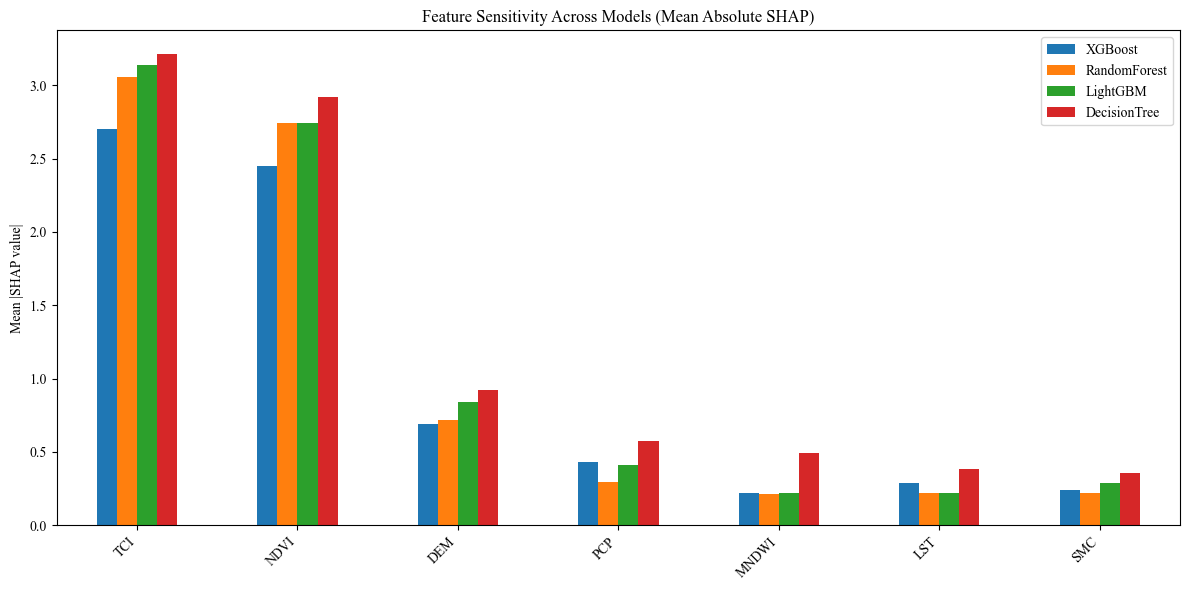

In [41]:
df_compare.drop(columns=["Average"]).plot(kind="bar", figsize=(12, 6))
plt.title("Feature Sensitivity Across Models (Mean Absolute SHAP)")
plt.ylabel("Mean |SHAP value|")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Export SHAP Summary Plots (PNG/JPG, 300 dpi)

In [42]:
for name in ["XGBoost", "RandomForest", "LightGBM", "DecisionTree"]:
    print(f"Saving SHAP summary plot for {name}...")

    shap_values = shap_values_models[name]

    # Downsample together → must match shapes
    X_plot = shap.sample(X, 500, random_state=42)
    shap_plot = shap_values[:len(X_plot)]

    plt.figure(figsize=(10, 6))

    shap.summary_plot(
        shap_plot,
        X_plot,
        max_display=20,
        show=False
    )

    plt.title(f"SHAP Summary Plot — {name}", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"SHAP_summary_{name}.jpg", dpi=300)
    plt.close()

Saving SHAP summary plot for XGBoost...
Saving SHAP summary plot for RandomForest...
Saving SHAP summary plot for LightGBM...
Saving SHAP summary plot for DecisionTree...


## Export SHAP Bar Plots (PNG/JPG, 300 dpi)

In [43]:
for name in ["XGBoost", "RandomForest", "LightGBM", "DecisionTree"]:
    print(f"Saving SHAP BAR plot for {name}...")

    shap_values = shap_values_models[name]

    plt.figure(figsize=(10, 6))

    shap.summary_plot(
        shap_values,
        X,
        plot_type="bar",
        show=False
    )

    plt.title(f"SHAP Bar Plot — {name}", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"SHAP_bar_{name}.jpg", dpi=300)
    plt.close()

Saving SHAP BAR plot for XGBoost...
Saving SHAP BAR plot for RandomForest...
Saving SHAP BAR plot for LightGBM...
Saving SHAP BAR plot for DecisionTree...
